In [ ]:
https://github.com/mariakhamitowa/yandex-practicum.git

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [109]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [110]:
data = pd.read_csv('/datasets/Churn.csv', index_col='RowNumber')

data['Tenure']=data['Tenure'].fillna(0).astype('int64')
data.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0


 <span style="color:blue">Решила заменить на 0, тк Tenure-это количество собственности и если значение пропущено, значит скорее всего клиент ничем не владеет,</span>

In [111]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.543400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,3.111573,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


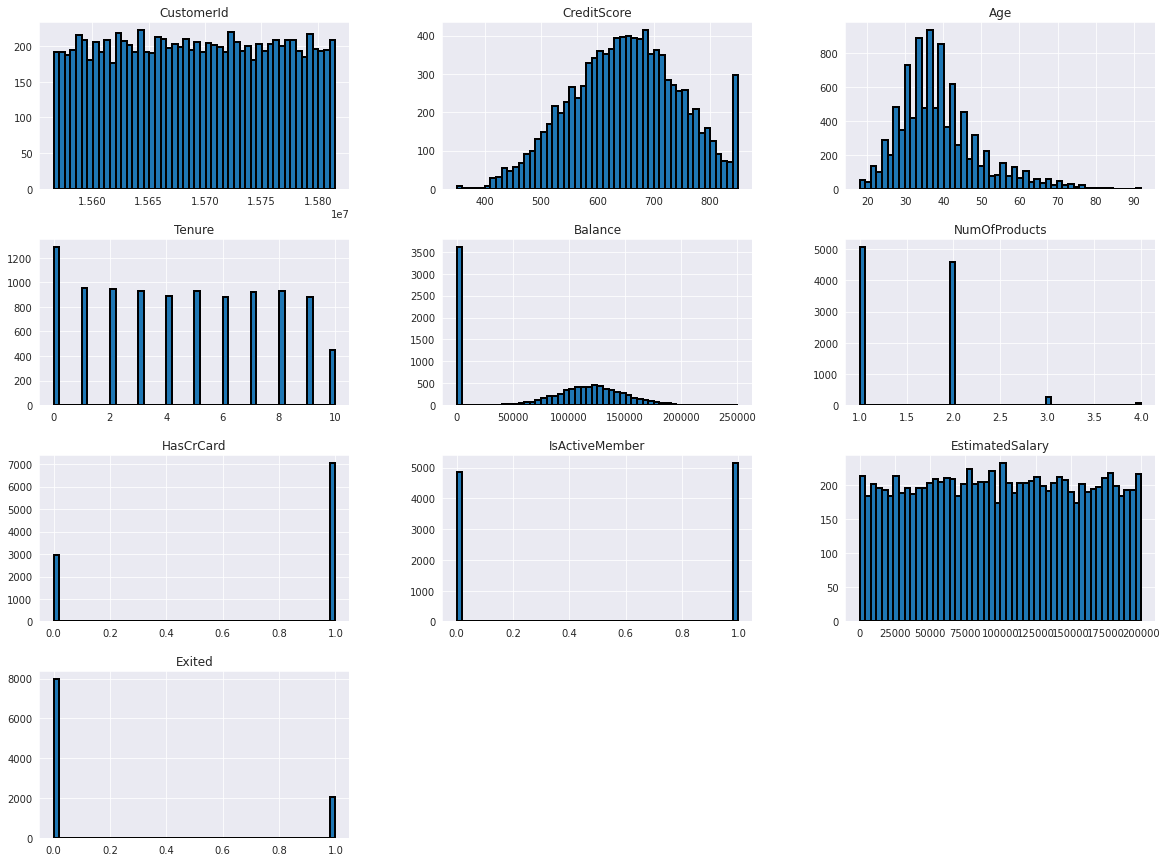

In [113]:
data.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2)
plt.show()

Можно будет удалить три столбца - "CustomerId","Surname", которые в нашем случае не несут полезной нагрузки

In [114]:
data.drop(["CustomerId","Surname"],axis= "columns", inplace= True)
data.shape

(10000, 11)

In [115]:
data.duplicated().sum()

0

Вывод
Отток клиентов - это потеря клиентов, выражающаяся в отсутствии покупок или платежей в течение определенного периода времени. 

Мы предварительно просмотрели наш набор данных:

Дубликатов не найдено, нет необходимости удалять строки.
в процессе подготовки объектов к анализу решила удалить столбцы "CustomerId","Surname".


## Исследование задачи

In [116]:
data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


One-hot Encoding

Категориальные признаки geography и gender должны быть преобразованы в числовые, нам нужны количественные характеристики, чтобы быть более точными

In [117]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [118]:
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [119]:

gender_ohe = pd.get_dummies(data["Gender"], drop_first=True)
country_ohe = pd.get_dummies(data["Geography"], drop_first=True)


data.drop(["Gender", "Geography"], axis=1, inplace=True)


df_ohe = pd.concat([data, gender_ohe, country_ohe], axis=1)

df_ohe.head(5)
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Age              10000 non-null  int64  
 2   Tenure           10000 non-null  int64  
 3   Balance          10000 non-null  float64
 4   NumOfProducts    10000 non-null  int64  
 5   HasCrCard        10000 non-null  int64  
 6   IsActiveMember   10000 non-null  int64  
 7   EstimatedSalary  10000 non-null  float64
 8   Exited           10000 non-null  int64  
 9   Male             10000 non-null  uint8  
 10  Germany          10000 non-null  uint8  
 11  Spain            10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 810.5 KB


Разделим данные

Разделим наши выборки на обучающие, валидационные для выбора гиперпараметров и тестовые, на которых мы будем тестировать нашу модель.

In [120]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [121]:
features, target = split_data(df_ohe,'Exited')

Мы получаем проверочную выборку в размере 20% и снова делим оставшиеся 80%, чтобы получить тестовую выборку. Мы проведем обучение на 60% данных

In [122]:
features_df, features_valid, target_df, target_valid = ( 
                                train_test_split(
                                features, target, test_size=0.20, random_state=42)
)

In [123]:
features_train, features_test, target_train, target_test = ( 
                                train_test_split(
                                features_df, target_df, test_size=0.25, random_state=42)
)

In [124]:
print('Objects of train:', len(features_train))
print('Objects of valid:', len(features_valid))
print('Objects of test:', len(features_test))
print('Sum of objects:', len(features_train) + len(features_test) + len(features_test))
print()
print('Objects of original set (check sum):', len(df_ohe))

Objects of train: 6000
Objects of valid: 2000
Objects of test: 2000
Sum of objects: 10000

Objects of original set (check sum): 10000


Выборка была разделена, мы можем приступить к пробному обучению моделей. В нашей задаче наблюдается сильный классовый дисбаланс, который плохо сказывается на обучении модели.Посмотрим на результаты,  оценим модель по показателю F1. 


Масштабирование  по всему набору данных может привести к утечке данных, нужно только обучить на train.

Мы обучим, а затем применим к нашим образцам

In [125]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
RowNumber,,,,,,,,,,,
8589,0.626553,-0.948125,7,0.026803,1,1,0,0.389943,0,0,1
3179,-1.143262,0.006684,4,0.538874,2,1,1,-1.026089,0,0,0
5201,-1.455583,0.293126,9,0.283178,2,1,0,-1.486725,1,1,0
8890,-0.747657,0.006684,9,0.833254,1,1,0,-0.246001,0,0,0
5790,0.387107,1.534377,1,0.000856,1,1,0,-1.006993,0,1,0


Теперь применим к валидационным данным

In [126]:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
RowNumber,,,,,,,,,,,
6253,-0.581086,-0.661682,3,0.327195,2,0,0,-1.017034,1,1,0
4685,-0.299998,0.388607,1,-1.218934,2,1,1,0.805136,1,0,0
1732,-0.529032,0.484088,4,-1.218934,2,1,0,-0.724818,0,0,1
4743,-1.518047,1.916301,8,0.686002,2,1,1,1.228495,1,1,0
4522,-0.955870,-1.139087,7,0.779430,1,1,1,0.252697,0,0,1


Теперь применим к тестовым данным

In [127]:
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
RowNumber,,,,,,,,,,,
3189,1.553103,-0.661682,4,-0.017150,1,1,1,-1.084803,0,0,0
8294,1.188729,-1.043606,4,0.231074,1,0,1,-1.368802,0,1,0
1711,1.834191,-1.043606,8,0.935642,1,1,0,-0.362538,1,0,1
7511,1.521871,-0.279759,1,-1.218934,2,1,1,1.025781,1,0,0
1462,-0.424926,-0.470721,4,-1.218934,2,1,0,1.233214,1,0,1


Пробное обучение моделей без учета классового дисбаланса

Logistic regression

In [128]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.29158878504672897


Random forest

In [129]:
for max_depth in range(1,20,1):
    model=RandomForestClassifier(max_depth=max_depth,n_estimators=50,random_state=1234)
    model.fit(features_train, target_train)
  
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('max_depth:',max_depth,"F1:", f1_score(target_valid, predicted_valid))

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.2
max_depth: 3 F1: 0.23111111111111107
max_depth: 4 F1: 0.3610547667342799
max_depth: 5 F1: 0.4220532319391635
max_depth: 6 F1: 0.4883303411131059
max_depth: 7 F1: 0.531986531986532
max_depth: 8 F1: 0.5636070853462158
max_depth: 9 F1: 0.5585874799357946
max_depth: 10 F1: 0.5544871794871794
max_depth: 11 F1: 0.5741324921135647
max_depth: 12 F1: 0.5678627145085803
max_depth: 13 F1: 0.5709828393135725
max_depth: 14 F1: 0.5616224648985959
max_depth: 15 F1: 0.5692068429237946
max_depth: 16 F1: 0.5691573926868045
max_depth: 17 F1: 0.5692068429237946
max_depth: 18 F1: 0.5749613601236476
max_depth: 19 F1: 0.5700934579439252


In [130]:
for estim in range(1,50,2):
    model=RandomForestClassifier(max_depth=11,n_estimators=estim,random_state=1234)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('estim',estim,'F1:',f1_score(target_valid, predicted_valid))

estim 1 F1: 0.4868804664723032
estim 3 F1: 0.5365853658536586
estim 5 F1: 0.5555555555555556
estim 7 F1: 0.5633802816901408
estim 9 F1: 0.5536
estim 11 F1: 0.5736925515055467
estim 13 F1: 0.5700636942675159
estim 15 F1: 0.5650793650793651
estim 17 F1: 0.5741324921135647
estim 19 F1: 0.5691823899371069
estim 21 F1: 0.5627980922098569
estim 23 F1: 0.5655608214849921
estim 25 F1: 0.5627980922098569
estim 27 F1: 0.5627980922098569
estim 29 F1: 0.5641838351822505
estim 31 F1: 0.5718799368088467
estim 33 F1: 0.5718799368088467
estim 35 F1: 0.5750394944707741
estim 37 F1: 0.5691573926868045
estim 39 F1: 0.5723370429252782
estim 41 F1: 0.5728000000000001
estim 43 F1: 0.5768621236133121
estim 45 F1: 0.5759493670886077
estim 47 F1: 0.5750394944707741
estim 49 F1: 0.5759493670886077


Вывод: лучшее значение max_depth=11 при котором F1=0.5741 и n_estimators=49 при котором F1=0.575

Вывод


Перед нами стоит задача классификации. Чтобы улучшить результаты прогнозирования и облегчить обучение модели, мы преобразовали данные:


, проведено кодирование категориальных переменных
, проведено масштабирование количественных переменных
, разделены выборки в соотношении 60%: 20%: 20% - обучение, валидация для выбора гиперпараметров и верификации модели, тест - для окончательной верификации модели и оценки
Мы попытались обучить модели на объектах с дисбалансом классов. Теперь попробую избавиться от этой проблемы, выбрав гиперпараметры модели.

## Борьба с дисбалансом

In [131]:
data['Exited'].value_counts().to_frame()

,Exited
0,7963
1,2037


Разделю обучающую выборку на отрицательные и положительные объекты
скопируем положительные объекты несколько раз
с учетом полученных данных, создадим новую обучающую выборку
перетасуем данные

In [132]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

    
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

print(features_upsampled.shape)
print(target_upsampled.shape)

(10924, 11)
(10924,)


In [133]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

In [134]:
counter = Counter(target_upsampled)
print(counter)

Counter({1: 6155, 0: 4769})


Logistic regression

In [135]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4695121951219512


Мы наблюдаем небольшое увеличение показателя, близкое к тому, которое мы получили, указав параметр class_weight

Random Forest

In [136]:
%%time

for max_depth in range(1,20,1):

    model=RandomForestClassifier(class_weight='balanced',max_depth=max_depth,n_estimators=50,random_state=1234)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('max_depth:',max_depth,"F1:", f1_score(target_valid, predicted_valid))

max_depth: 1 F1: 0.5469061876247505
max_depth: 2 F1: 0.5657894736842105
max_depth: 3 F1: 0.5749761222540593
max_depth: 4 F1: 0.5891325071496663
max_depth: 5 F1: 0.6061814556331007
max_depth: 6 F1: 0.6073926073926074
max_depth: 7 F1: 0.6174089068825911
max_depth: 8 F1: 0.6208333333333333
max_depth: 9 F1: 0.6186895810955961
max_depth: 10 F1: 0.6195652173913043
max_depth: 11 F1: 0.6266968325791855
max_depth: 12 F1: 0.6171967020023558
max_depth: 13 F1: 0.6002460024600246
max_depth: 14 F1: 0.601010101010101
max_depth: 15 F1: 0.6010230179028133
max_depth: 16 F1: 0.6028460543337646
max_depth: 17 F1: 0.6236559139784945
max_depth: 18 F1: 0.6032608695652175
max_depth: 19 F1: 0.6091644204851752
CPU times: user 6.98 s, sys: 99.1 ms, total: 7.07 s
Wall time: 7.12 s


In [137]:
%%time

for estim in range(1,60,1):

    model=RandomForestClassifier(class_weight='balanced',max_depth=11,n_estimators=estim,random_state=1234)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('estim',estim,"F1:", f1_score(target_valid, predicted_valid))

estim 1 F1: 0.5189873417721519
estim 2 F1: 0.5071868583162218
estim 3 F1: 0.5447070914696814
estim 4 F1: 0.5515743756786102
estim 5 F1: 0.5723612622415669
estim 6 F1: 0.5944751381215468
estim 7 F1: 0.6031042128603104
estim 8 F1: 0.5962596259625963
estim 9 F1: 0.5991189427312775
estim 10 F1: 0.6116071428571428
estim 11 F1: 0.6068660022148393
estim 12 F1: 0.6124721603563476
estim 13 F1: 0.6107382550335572
estim 14 F1: 0.6134831460674157
estim 15 F1: 0.6164229471316085
estim 16 F1: 0.6125714285714287
estim 17 F1: 0.6169491525423729
estim 18 F1: 0.6174801362088536
estim 19 F1: 0.6127946127946129
estim 20 F1: 0.6150392817059482
estim 21 F1: 0.6159014557670772
estim 22 F1: 0.6159014557670772
estim 23 F1: 0.6138392857142858
estim 24 F1: 0.6192090395480225
estim 25 F1: 0.6129398410896708
estim 26 F1: 0.6167800453514739
estim 27 F1: 0.6139954853273139
estim 28 F1: 0.6148648648648648
estim 29 F1: 0.6155580608793687
estim 30 F1: 0.607909604519774
estim 31 F1: 0.6145124716553287
estim 32 F1: 0.612

In [138]:
%%time


model_forest=RandomForestClassifier(class_weight='balanced',max_depth=11,n_estimators=55,random_state=1234)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.626560726447219
CPU times: user 490 ms, sys: 3.87 ms, total: 494 ms
Wall time: 503 ms


Здесь также есть улучшение

Downsampling

Воспользуемся функцией, которая выполняет следующие преобразования:

разделим обучающую выборку на отрицательные и положительные объекты
случайным образом отбросим некоторые из отрицательных объектов
с учетом полученных данных, создадим новую обучающую выборку
перетасуем данные

In [139]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=0.1, random_state=12345)
    target_sample = target_zeros.sample(frac=0.1, random_state=12345)
    
    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)
    

    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

print(features_downsampled.shape)
print(target_downsampled.shape)

(1708, 11)
(1708,)


In [140]:
counter = Counter(target_downsampled)
print(counter)

Counter({1: 1231, 0: 477})


 <span style="color:blue">Получается, что на наших данных upsample работает лучше чем downsample</span>

Logistic regression

In [141]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4006550218340612


Изменим порог
Для удобства мы переведем близость к классам в вероятность классов (у нас есть два класса - 0 и 1). Вероятности класса "1" нам достаточно. По умолчанию он равен 0,5 - попробуем другие параметры, например, до 0,95

Logistic regression

Threshold = 0.00 | Precision = 0.197, Recall = 1.000 | F1-score = 0.328
Threshold = 0.05 | Precision = 0.213, Recall = 0.980 | F1-score = 0.349
Threshold = 0.10 | Precision = 0.259, Recall = 0.924 | F1-score = 0.405
Threshold = 0.15 | Precision = 0.309, Recall = 0.832 | F1-score = 0.451
Threshold = 0.20 | Precision = 0.375, Recall = 0.728 | F1-score = 0.495
Threshold = 0.25 | Precision = 0.418, Recall = 0.616 | F1-score = 0.498
Threshold = 0.30 | Precision = 0.485, Recall = 0.524 | F1-score = 0.504
Threshold = 0.35 | Precision = 0.514, Recall = 0.430 | F1-score = 0.468
Threshold = 0.40 | Precision = 0.539, Recall = 0.331 | F1-score = 0.410
Threshold = 0.45 | Precision = 0.546, Recall = 0.257 | F1-score = 0.349
Threshold = 0.50 | Precision = 0.549, Recall = 0.198 | F1-score = 0.292
Threshold = 0.55 | Precision = 0.634, Recall = 0.150 | F1-score = 0.243
Threshold = 0.60 | Precision = 0.662, Recall = 0.120 | F1-score = 0.203
Threshold = 0.65 | Precision = 0.609, Recall = 0.071 | F1-score 

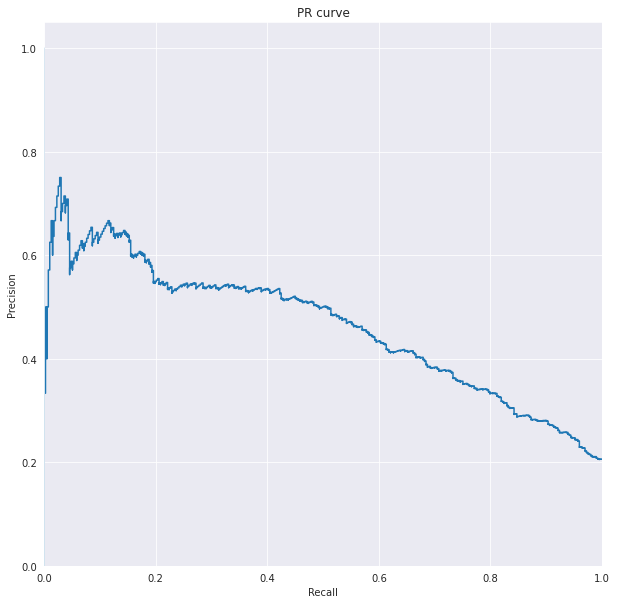

In [142]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

При пороге 0 полнота равна 1 - все ответы положительные. При пороге 0,85 модель перестает давать правильные ответы. Самое высокое значение F1 наблюдается при пороге 0,25

Random forest

Threshold = 0.00 | Precision = 0.278, Recall = 0.908 | F1-score = 0.426
Threshold = 0.05 | Precision = 0.278, Recall = 0.908 | F1-score = 0.426
Threshold = 0.10 | Precision = 0.372, Recall = 0.804 | F1-score = 0.509
Threshold = 0.15 | Precision = 0.372, Recall = 0.804 | F1-score = 0.509
Threshold = 0.20 | Precision = 0.463, Recall = 0.718 | F1-score = 0.563
Threshold = 0.25 | Precision = 0.463, Recall = 0.718 | F1-score = 0.563
Threshold = 0.30 | Precision = 0.553, Recall = 0.641 | F1-score = 0.594
Threshold = 0.35 | Precision = 0.553, Recall = 0.641 | F1-score = 0.594
Threshold = 0.40 | Precision = 0.607, Recall = 0.522 | F1-score = 0.561
Threshold = 0.45 | Precision = 0.607, Recall = 0.522 | F1-score = 0.561
Threshold = 0.50 | Precision = 0.713, Recall = 0.430 | F1-score = 0.537
Threshold = 0.55 | Precision = 0.713, Recall = 0.430 | F1-score = 0.537
Threshold = 0.60 | Precision = 0.770, Recall = 0.366 | F1-score = 0.497
Threshold = 0.65 | Precision = 0.770, Recall = 0.366 | F1-score 

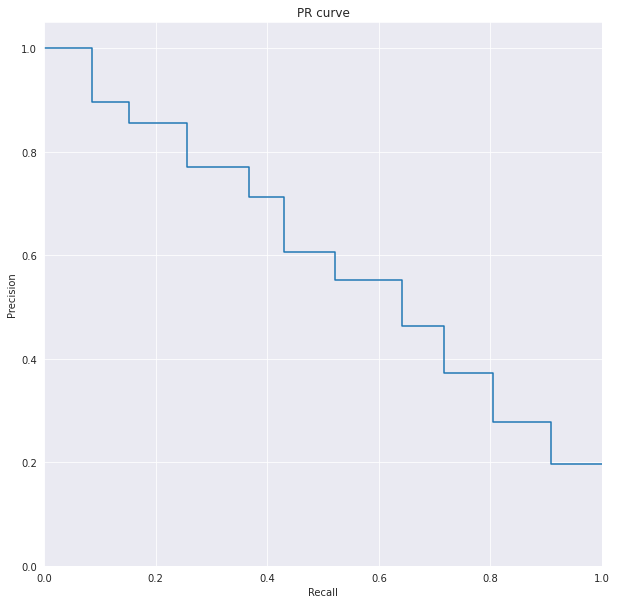

In [143]:
model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

Самый высокий показатель достигается при пороге в 0,2

Давайте выберем повышающую дискретизацию, увеличивающую выборку. На нем мы будем обучать наши модели и выбирать гиперпараметры. Мы не будем изменять пороговое значение или сокращать выборку

Буду обучать модель на увеличенной выборке, проверять параметры на валидационной выборке и оценивать ее с помощью F1-меры, мы не будем использовать перекрестную валидацию для логистической регрессии и случайного леса.

Параметры будут выбраны с помощью GridSearchCV. цикл и перечисление использоваться не будут

Logistic regression

In [144]:
par_grid_logist = {
                   'intercept_scaling': [0.5, 1.0],
                   'class_weight': [None, 'balanced'],
                   'C': [0.5, 1]
                   }
model = LogisticRegression(solver='liblinear',random_state=42)

grid_search = GridSearchCV(model, par_grid_logist, cv=5,
                           scoring='f1')
grid_search.fit(features_upsampled, target_upsampled)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': [0.5, 1, 1.5], 'class_weight': [None, 'balanced'],
                         'intercept_scaling': [0.5, 1.0, 1.5]},
             scoring='f1')

In [145]:
grid_search.best_params_

{'C': 1.5, 'class_weight': None, 'intercept_scaling': 0.5}

применим наши параметры и посмотрим на результат:

In [146]:
model_lreg = LogisticRegression(C=1.5, class_weight=None, intercept_scaling=0.5,
                                solver='liblinear', random_state=42
)
model_lreg.fit(features_upsampled, target_upsampled)
predicted_valid = model_lreg.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.46987032799389783


Ниже порога 0.59 давайте посмотрим, как модель будет вести себя во время тестирования

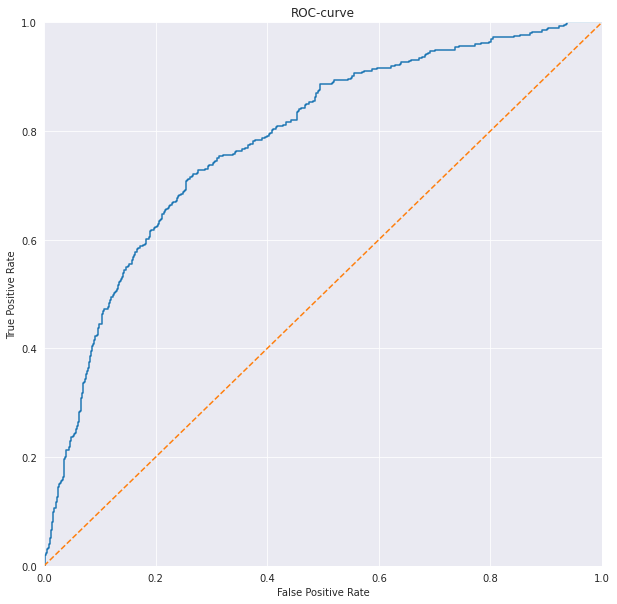

AUC: 0.7819875196144096


In [147]:
probabilities_valid = model_lreg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

AUC больше 0,5,  модель стала лучше

Random forest

In [148]:
par_grid_ensemble = {'n_estimators': [3, 10, 30],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5,
                           scoring='accuracy'
                          )
grid_search.fit(features_upsampled, target_upsampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': range(5, 15),
                         'n_estimators': [3, 10, 30]},
             scoring='accuracy')

In [149]:
grid_search.best_params_

{'criterion': 'entropy', 'min_samples_split': 5, 'n_estimators': 30}

In [150]:
model_rfc = RandomForestClassifier(random_state=42, criterion='gini', 
                               min_samples_split=5, n_estimators=30
                              )
model_rfc.fit(features_upsampled, target_upsampled)
predicted_valid = model_rfc.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5922974767596282


Выше порогового значения 0,59, проверим test и посмотрим, как модель ведет себя на незнакомых данных

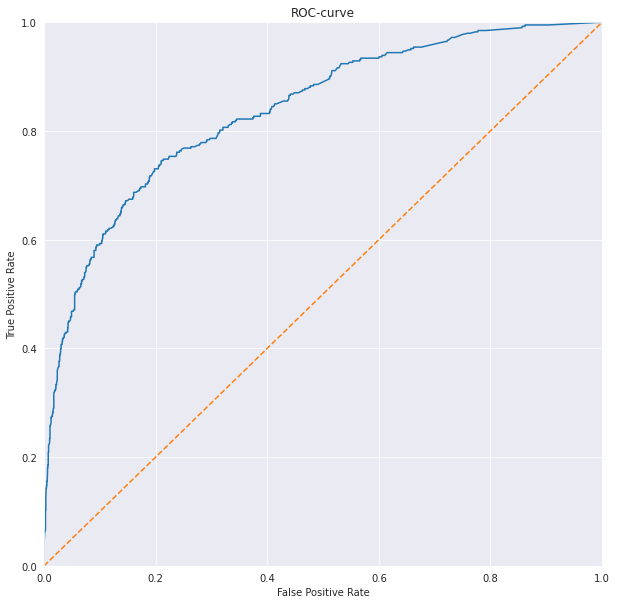

AUC: 0.8377969475149276


In [151]:
probabilities_valid = model_rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

AUC также говорит нам, что модель является лучшей.

## Тестирование модели

In [152]:
table_of_model = []
table_of_prec = []
table_of_acc = []



Logistic regression

In [153]:
predictions_test = model_lreg.predict(features_test)
test_f1 = f1_score(target_test, predictions_test)
test_acc = accuracy_score(target_test, predictions_test)

print("Accuracy")
print("Test set:", test_acc)
print("F1-мера")
print("Test set:", test_f1)

table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('LogisticRegression')

Accuracy
Test set: 0.6675
F1-мера
Test set: 0.5041014168530947


Random forest

In [154]:
predictions_test = model_rfc.predict(features_test)
test_f1 = f1_score(target_test, predictions_test)
test_acc = accuracy_score(target_test, predictions_test)

print("Accuracy")
print("Test set:", test_acc)
print("F1-мера")
print("Test set:", test_f1)

table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('RandomForestClassifier')

Accuracy
Test set: 0.85
F1-мера
Test set: 0.6124031007751938


In [155]:
model_rfc.feature_importances_

array([0.1331455 , 0.25286522, 0.08074677, 0.1412647 , 0.13306449,
       0.01851208, 0.03407288, 0.13772004, 0.02159708, 0.03121515,
       0.0157961 ])

In [156]:
features_test.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Male', 'Germany', 'Spain'],
      dtype='object')

In [157]:
fi = pd.DataFrame({'name':features_test.columns,'fi':model_rfc.feature_importances_})
fi.sort_values('fi',ascending=False)

,name,fi
1,Age,0.252865
3,Balance,0.141265
7,EstimatedSalary,0.137720
0,CreditScore,0.133145
4,NumOfProducts,0.133064
2,Tenure,0.080747
6,IsActiveMember,0.034073
9,Germany,0.031215
8,Male,0.021597
5,HasCrCard,0.018512


Вывод
Нам были предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. На основе этих данных мы сформировали функции для обучения модели с целью прогнозирования оттока клиентов. Мы достигли наилучших результатов с моделью, основанной на алгоритме Cлучайного леса.



In [158]:
fi.sort_values('fi',ascending=False).reset_index(drop=True).head()

,name,fi
0,Age,0.252865
1,Balance,0.141265
2,EstimatedSalary,0.137720
3,CreditScore,0.133145
4,NumOfProducts,0.133064


Наиболее важными признаками, на которые следует обратить внимание, являются:

Возраст клиента
Остаток на счете
Ожидаемая прибыль


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*